In [1]:
%matplotlib notebook
from ipywidgets import *

import os
import pandas as pd
import ast

import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import numpy as np

import glob

%matplotlib inline

from my_library import *

In [2]:
data_directory = '../chess_resources/csv'

csv_files = glob.glob(data_directory + "/*.csv")
print("Found " + str(len(csv_files)) + " csv files")

constrains = []
for file in csv_files:
    constrains.append(file.split("/")[-1].split(".")[0])

# to python array
constrains = [ast.literal_eval(c) for c in constrains]

for c in constrains:
    print(c)

constraint_piece_indexes = {
    'queen': 0,
    'rook': 1,
    'bishop': 2,
    'knight': 3,
    'pawn': 4
}

# filter negligible values
treshold_percent = 0.05
print("\nSetting treshold for negligible values to " + str(treshold_percent) + "%")

Found 10 csv files
(1, 2, 2, 2, 7)
(1, 2, 2, 1, 8)
(1, 2, 1, 2, 8)
(0, 2, 2, 2, 8)
(1, 2, 2, 1, 7)
(1, 2, 1, 2, 7)
(0, 2, 2, 2, 7)
(1, 2, 1, 1, 7)
(1, 2, 2, 0, 7)
(1, 2, 0, 2, 7)

Setting treshold for negligible values to 0.05%


# Load All Constraints

In [3]:
dfs = {}

for file, constraint in zip(csv_files, constrains):
    print("Reading file " + file)
    df = pd.read_csv(file, sep=";")
    print('\tshape: ', df.shape)
    dfs[constraint] = df

one_df = dfs[(1, 2, 2, 2, 7)]
display("Displaying df format:")
display(one_df.head())
display(df.dtypes)

Reading file ../chess_resources/csv/(1, 2, 2, 2, 7).csv
	shape:  (6649778, 13)
Reading file ../chess_resources/csv/(1, 2, 2, 1, 8).csv
	shape:  (1361963, 13)
Reading file ../chess_resources/csv/(1, 2, 1, 2, 8).csv
	shape:  (1617265, 13)
Reading file ../chess_resources/csv/(0, 2, 2, 2, 8).csv
	shape:  (87438, 13)
Reading file ../chess_resources/csv/(1, 2, 2, 1, 7).csv
	shape:  (2695253, 13)
Reading file ../chess_resources/csv/(1, 2, 1, 2, 7).csv
	shape:  (2174561, 13)
Reading file ../chess_resources/csv/(0, 2, 2, 2, 7).csv
	shape:  (339271, 13)
Reading file ../chess_resources/csv/(1, 2, 1, 1, 7).csv
	shape:  (1642516, 13)
Reading file ../chess_resources/csv/(1, 2, 2, 0, 7).csv
	shape:  (444233, 13)
Reading file ../chess_resources/csv/(1, 2, 0, 2, 7).csv
	shape:  (327842, 13)


'Displaying df format:'

,id,result,white_elo,black_elo,time_control,eco,opening,satisfied_after,queen_pos,rook_pos,bishop_pos,knight_pos,pawn_pos
0,2,1,1968,1893,300+0,D35,"Queen's Gambit Declined: Exchange Variation, P...",7,"[3,]","[0,7,]","[2,5,]","[6,18,]","[8,9,12,13,14,15,27,]"
1,3,0,1204,1461,300+0,C44,Ponziani Opening,7,"[3,]","[0,7,]","[2,5,]","[1,21,]","[8,9,13,14,15,18,28,]"
2,4,1,1859,1772,600+0,C31,"King's Gambit Declined: Falkbeer, Milner-Barry...",5,"[3,]","[0,7,]","[2,5,]","[6,18,]","[8,9,10,11,14,15,28,]"
3,5,1,1882,1868,300+0,B10,Caro-Kann Defense,5,"[3,]","[0,7,]","[2,5,]","[1,21,]","[8,9,10,11,13,14,15,]"
4,6,1,1867,1905,600+0,A07,King's Indian Attack: Sicilian Variation,5,"[3,]","[0,7,]","[2,5,]","[1,21,]","[8,9,11,12,13,15,22,]"


id                  int64
result              int64
white_elo           int64
black_elo           int64
time_control       object
eco                object
opening            object
satisfied_after     int64
queen_pos          object
rook_pos           object
bishop_pos         object
knight_pos         object
pawn_pos           object
dtype: object

# Removing Very Beginner Games

In [4]:
bad_game_elo_threshold = 1000
display('Removing games with white elo < ' + str(bad_game_elo_threshold))

for constraint, df in dfs.items():
    original_count = df.shape[0]
    df = df[df['white_elo'] > bad_game_elo_threshold]
    new_count = df.shape[0]
    print('Removed ' + str(original_count - new_count) + ' games out of ' + str(original_count) + ' (' + str(round((original_count - new_count) / original_count * 100, 2)) + '%)')

    dfs[constraint] = df

'Removing games with white elo < 1000'

Removed 32198 games out of 6649778 (0.48%)
Removed 8938 games out of 1361963 (0.66%)
Removed 8082 games out of 1617265 (0.5%)
Removed 2039 games out of 87438 (2.33%)
Removed 10834 games out of 2695253 (0.4%)
Removed 8248 games out of 2174561 (0.38%)
Removed 3530 games out of 339271 (1.04%)
Removed 5334 games out of 1642516 (0.32%)
Removed 1611 games out of 444233 (0.36%)
Removed 887 games out of 327842 (0.27%)


# Converting **arrays of positions** to python arrays

In [5]:
# first convert 'object' to arrays
arrays_columns = ['queen_pos', 'rook_pos', 'bishop_pos', 'knight_pos', 'pawn_pos']
#display(type(dfs[(1, 2, 2, 2, 7)]['queen_pos'][0]))

for constraint, df in dfs.items():
    for col in arrays_columns:
        df.loc[:, col] = df[col].apply(lambda x: ast.literal_eval(x))
    
    dfs[constraint] = df

#type(dfs[(1, 2, 2, 2, 7)]['queen_pos'][0])

# Analysing
## Correlation HeatMap

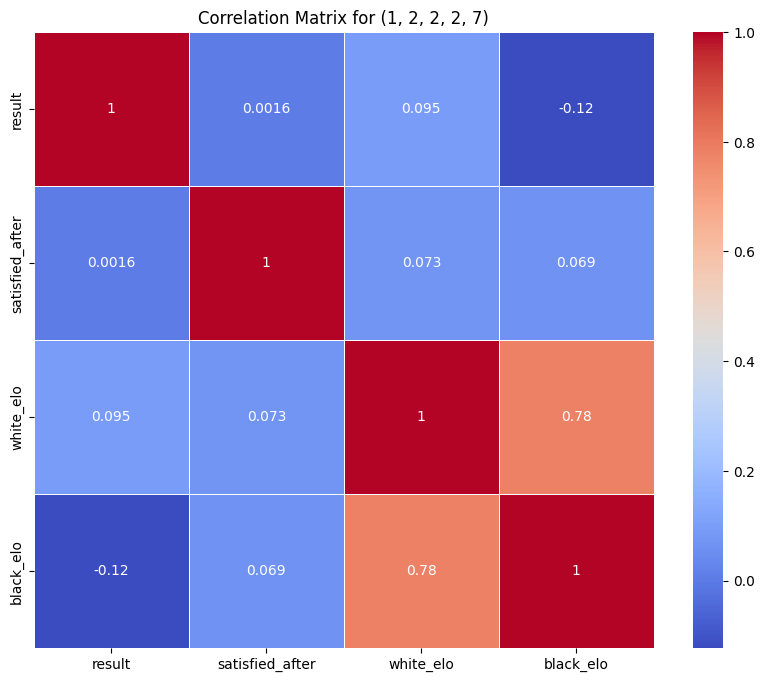

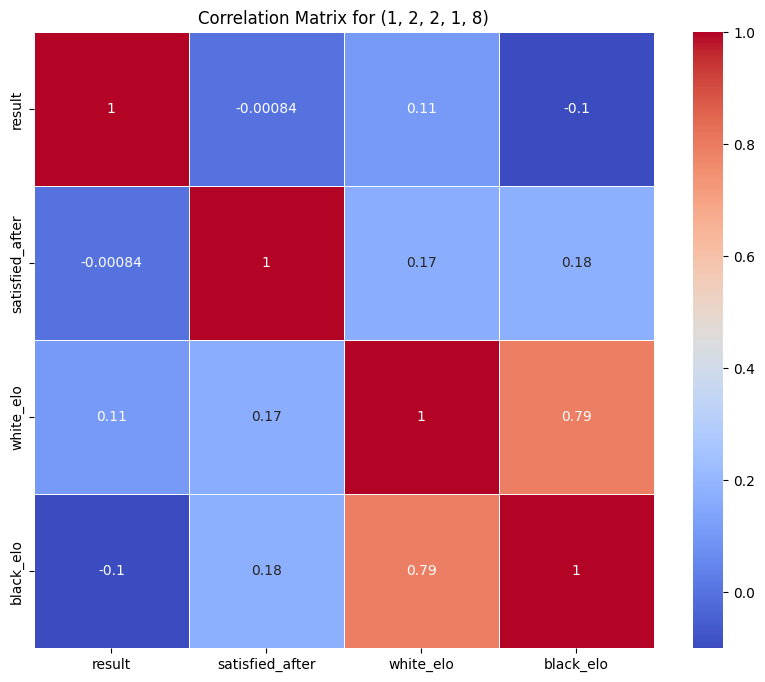

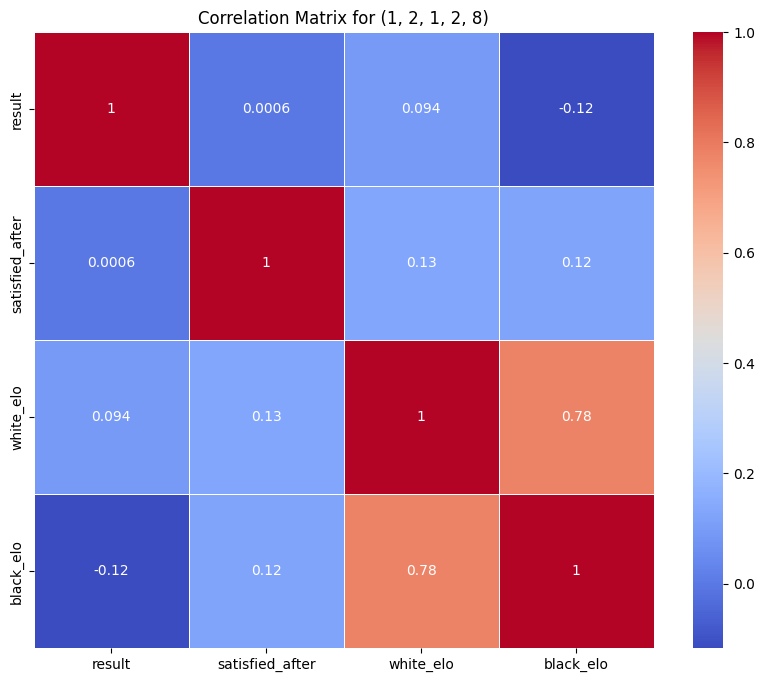

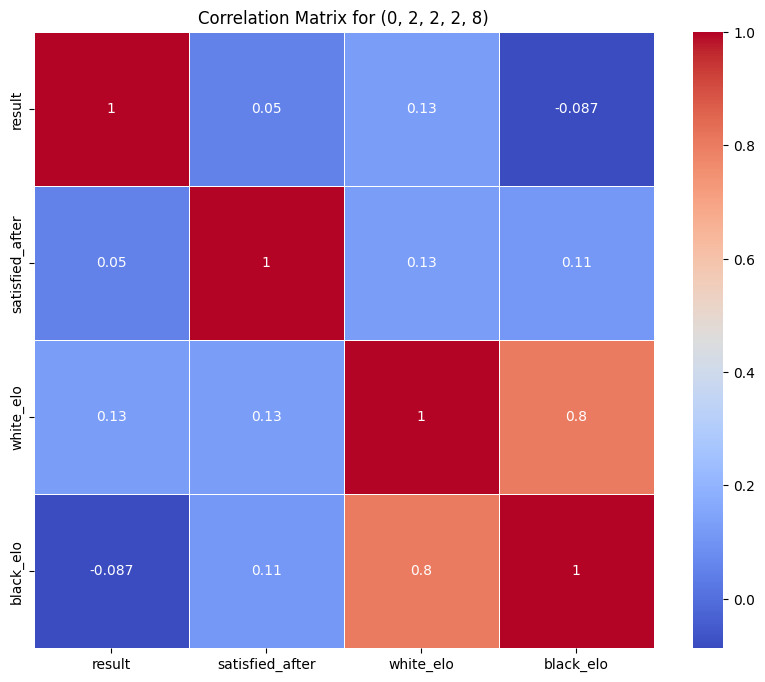

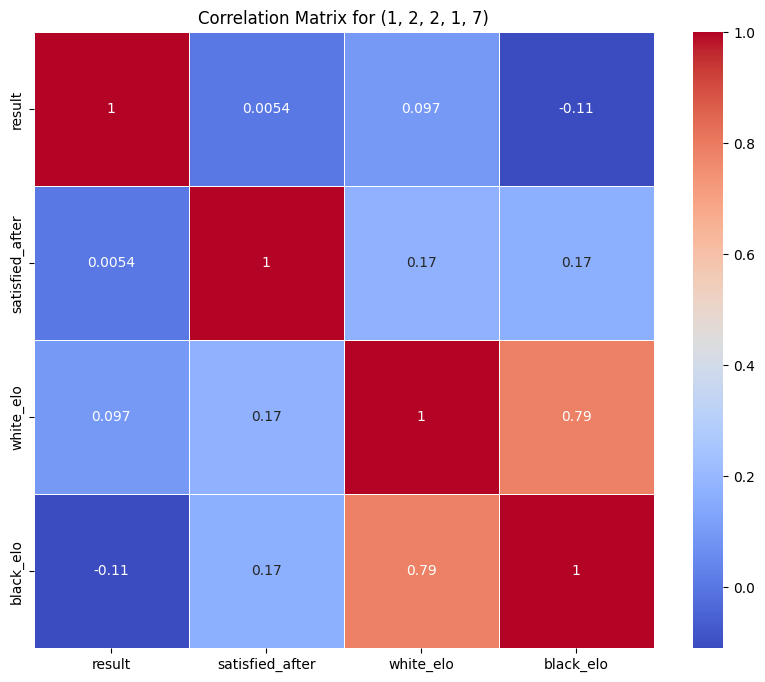

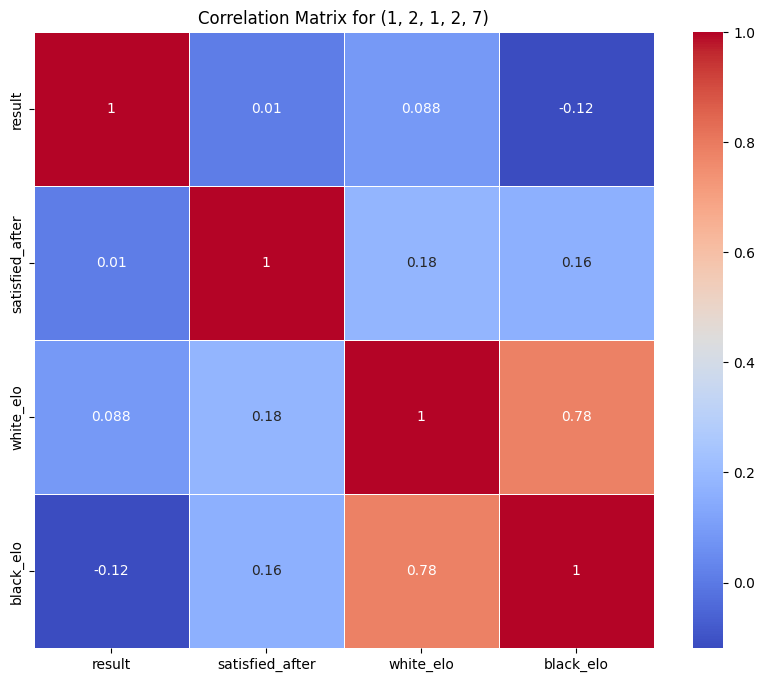

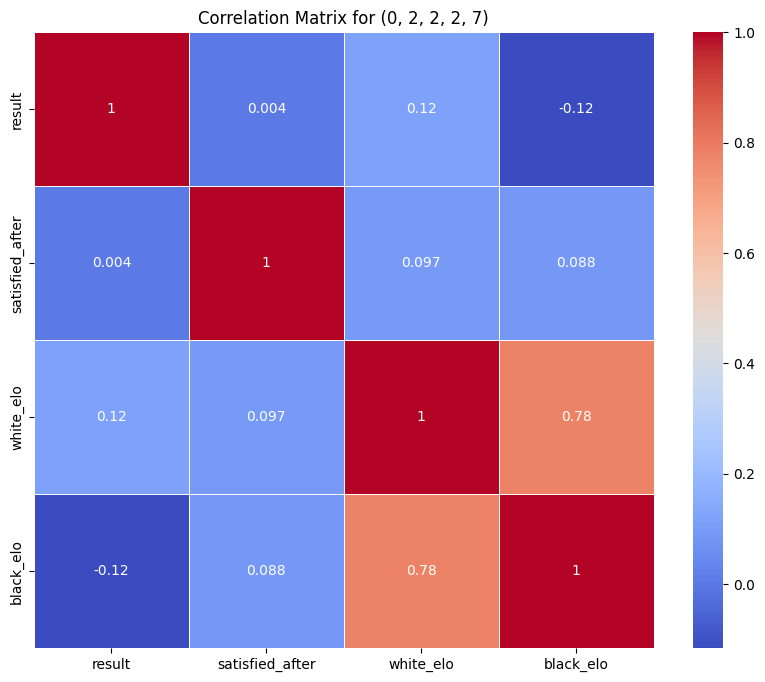

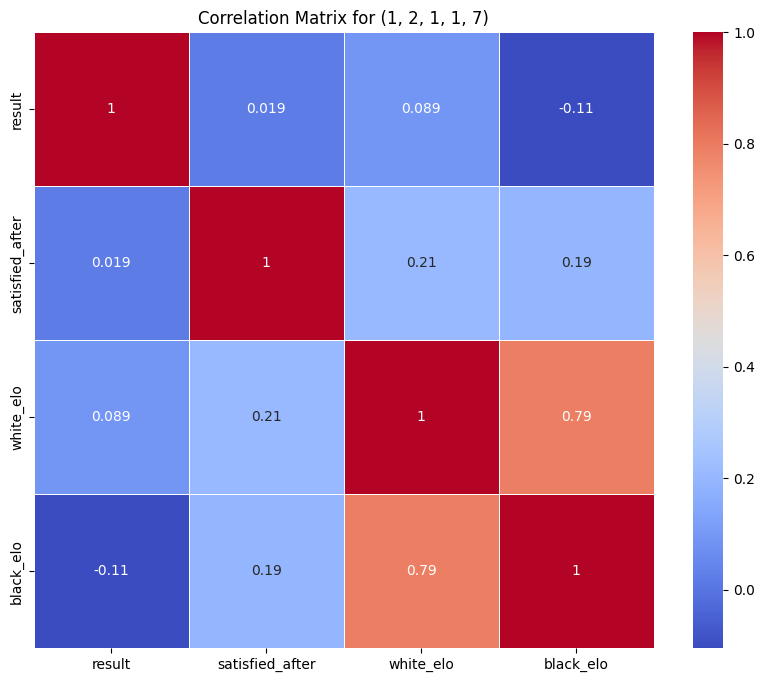

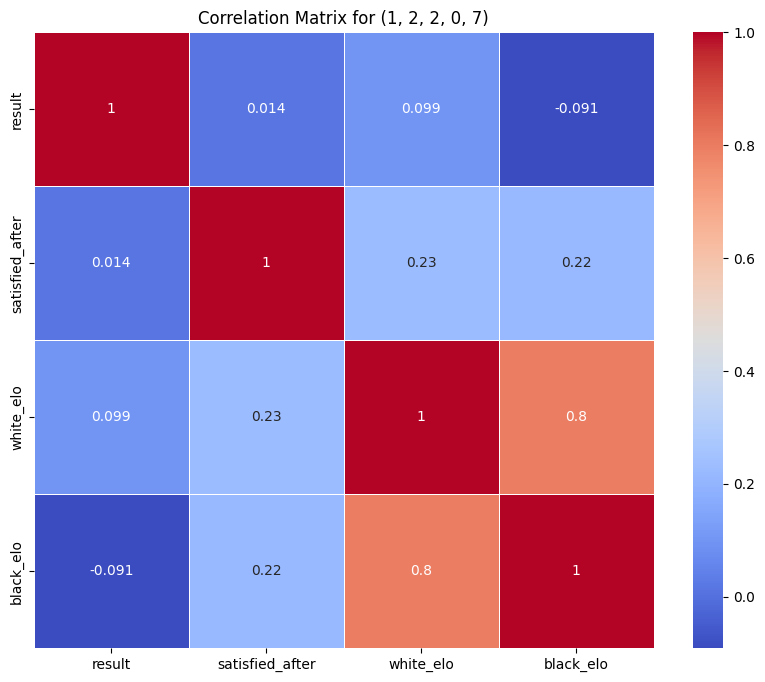

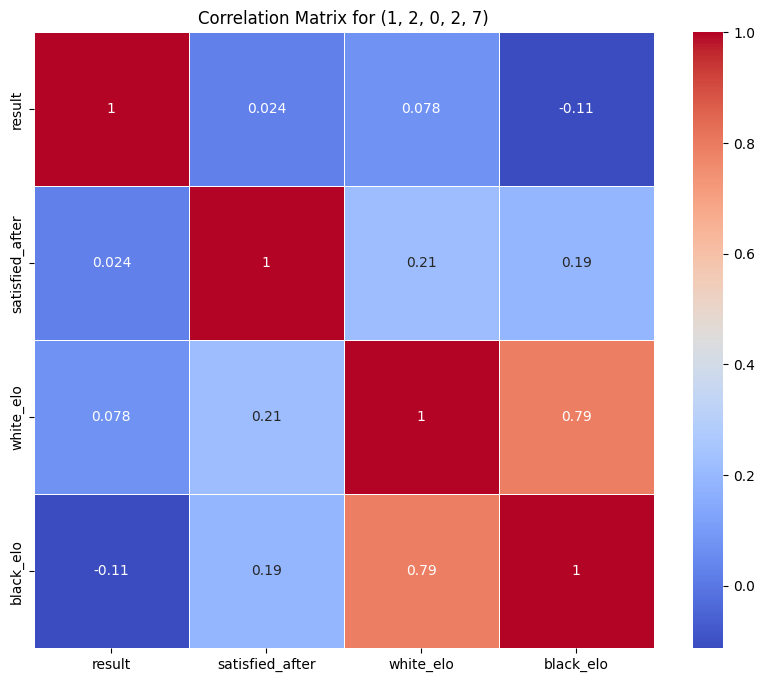

In [6]:
for constraint, df in dfs.items():
    corr_matrix = df[['result', 'satisfied_after', 'white_elo', 'black_elo']].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'Correlation Matrix for {constraint}')
    plt.show()

$=>$ Jeno **white_elo** a **black_elo** jsou korelované, ale to není překvapující. Mezi ostatními není žádná korelace.

## Drop unnecessary columns

In [7]:
columns_to_drop = ['id', 'white_elo', 'black_elo', 'time_control']
for constraint, df in dfs.items():
    df = df.drop(columns=columns_to_drop)
    dfs[constraint] = df

#display(dfs[(1, 2, 2, 2, 7)].head())

## Winning

,constraint,win,lost,draw,opening
0,"(1, 2, 2, 2, 7)",0.496317,0.503683,0,Scandinavian Defense: Mieses-Kotroc Variation
1,"(1, 2, 2, 1, 8)",0.501989,0.498011,0,Van't Kruijs Opening
2,"(1, 2, 1, 2, 8)",0.480659,0.519341,0,Van't Kruijs Opening
3,"(0, 2, 2, 2, 8)",0.420731,0.579269,0,King's Pawn Game: Wayward Queen Attack
4,"(1, 2, 2, 1, 7)",0.498663,0.501337,0,Scandinavian Defense: Mieses-Kotroc Variation
5,"(1, 2, 1, 2, 7)",0.473761,0.526239,0,Caro-Kann Defense
6,"(0, 2, 2, 2, 7)",0.471211,0.528789,0,Scandinavian Defense: Mieses-Kotroc Variation
7,"(1, 2, 1, 1, 7)",0.473504,0.526496,0,Scandinavian Defense: Mieses-Kotroc Variation
8,"(1, 2, 2, 0, 7)",0.496369,0.503631,0,Scandinavian Defense: Mieses-Kotroc Variation
9,"(1, 2, 0, 2, 7)",0.459329,0.540671,0,Caro-Kann Defense


<Figure size 1000x600 with 0 Axes>

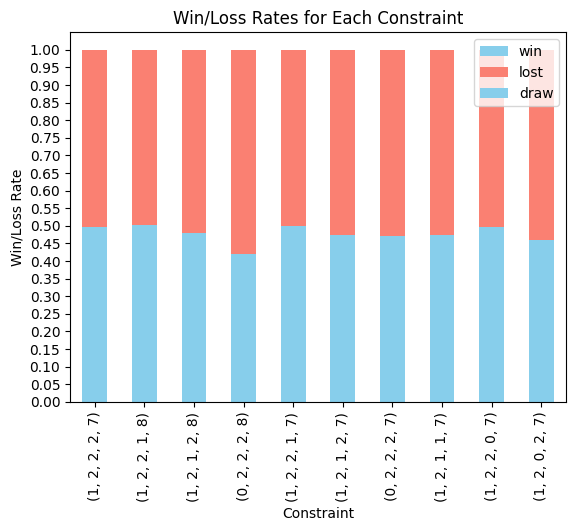

In [8]:
win_rate_df = pd.DataFrame(columns=['constraint', 'win', 'lost', 'draw', 'opening'])

for constraint, df in dfs.items():
    value_counts = df['result'].value_counts()
    prob_distribution = value_counts / value_counts.sum()

    most_common_opening = df['opening'].value_counts().idxmax()
    #opening_value_counts = df['opening'].value_counts().sort_values(ascending=False)

    win_rate_df.loc[len(win_rate_df)] = [
        constraint,
        prob_distribution.get(1, default=0),
        prob_distribution.get(0, default=0),
        prob_distribution.get(1/2, default=0),
        most_common_opening
    ]

display(win_rate_df)

#------------------------------------------------------------
#display(df['result'].describe())
#------------------------------------------------------------

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))
win_rate_df.plot(x='constraint', kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title('Win/Loss Rates for Each Constraint')
plt.xlabel('Constraint')
plt.ylabel('Win/Loss Rate')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.show()

This implies the current constrain combination **Does Not AFFECT** chance to win. This make sense as it is only start of the game.

## Number of satisfied Move

(1, 2, 2, 2, 7) Negligible values: Index([ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 39, 41, 43,
       45, 46, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 77, 85],
      dtype='int64', name='satisfied_after')
(1, 2, 2, 1, 8) Negligible values: Index([41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 65, 67, 69, 77, 85, 89, 97], dtype='int64', name='satisfied_after')
(1, 2, 1, 2, 8) Negligible values: Index([39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 75, 79, 81,
       85, 89, 93],
      dtype='int64', name='satisfied_after')
(0, 2, 2, 2, 8) Negligible values: Index([41, 43, 45, 47, 49, 53, 57, 61], dtype='int64', name='satisfied_after')
(1, 2, 2, 1, 7) Negligible values: Index([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 44, 47, 49, 51,
       53, 54, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 83, 87, 89,
       91, 93],
      dtype='int64', name='satisfied_after')
(1, 2, 1, 2, 7) Negligible values: Index([14, 16, 18, 20, 22

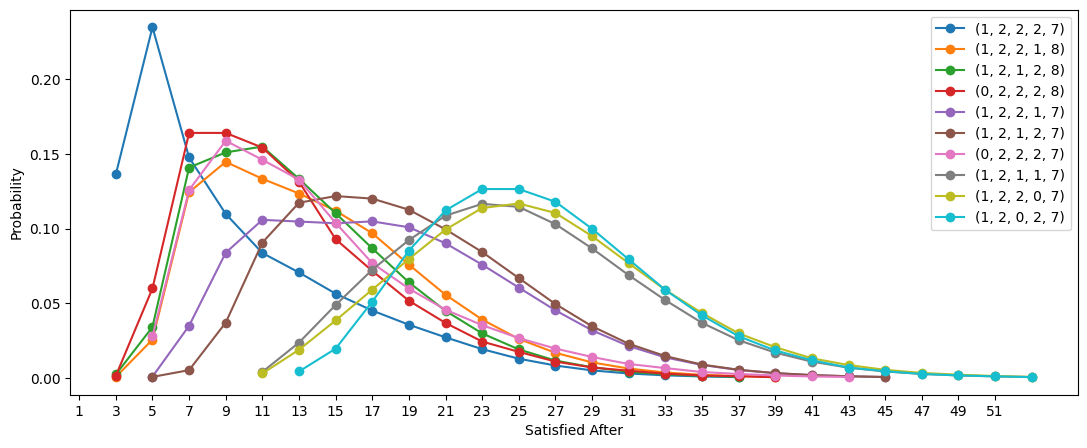

In [21]:
# display(df['satisfied_after'].describe())
# display('Median: ' + str(df['satisfied_after'].median()))

distributions = {}
for constraint, df in dfs.items():
    value_counts = df['satisfied_after'].value_counts()
    value_counts = value_counts.sort_index()

    threshold_value = (treshold_percent/100) * value_counts.sum()
    negligible_values = value_counts[value_counts <= threshold_value].index
    print(constraint, "Negligible values: " + str(negligible_values))

    value_counts = value_counts[value_counts > threshold_value]

    prob_distribution = value_counts / value_counts.sum()
    distributions[constraint] = prob_distribution

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))
for constraint, value_counts in distributions.items():
    axes.plot(value_counts.index, value_counts.values, marker='o', label=str(constraint))

plt.xlabel('Satisfied After')
plt.ylabel('Probability')
# set xticks 1 - 53 steps 2
axes.set_xticks(np.arange(1, 53, 2))
plt.legend()
plt.show()

The reason why all values are odd is because it's always white's move.<br/><br/>
$=>$ This Constraint is satisfied after **10** moves on average and median of **7** moves.

<br/>




## Piece positions

In [10]:
import math

def show_chessboard_heatmap(columnName):
    piece_value_counts = []
    for constraint, df in dfs.items():
        value_counts = df[columnName].explode().value_counts()
        value_counts = value_counts / value_counts.sum()
        piece_value_counts.append(value_counts)

    total_piece_value_counts = pd.concat(piece_value_counts, axis=1).mean(axis=1)

    square_probabs = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            square_number = i * 8 + j

            if square_number in total_piece_value_counts.index:
                square_probabs[i][j] = math.log(total_piece_value_counts[square_number] + 1)
            else:
                square_probabs[i][j] = 0

    square_probabs = np.flip(square_probabs, 0)

    heat_map = sns.heatmap(data=square_probabs, cmap='viridis', xticklabels=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'], yticklabels=['8', '7', '6', '5', '4', '3', '2', '1'])
    plt.show()

#### Queen


Negligible values: Index([[23], [29], [13], [63],  [1], [35], [50], [27], [36], [14], [49], [33],
       [34], [26], [47], [55], [16], [54], [28], [25], [40],  [9],  [5], [53],
       [37], [48], [15], [32], [42], [56],  [8],  [0], [46], [62], [45],  [6],
       [44], [43], [61], [58], [57], [41], [59], [52],  [7], [51], [60]],
      dtype='object', name='queen_pos')


/home/lukastp/gitlab/chess/notebooks/my_library.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, piece_df], ignore_index=True)


Negligible values: Index([[35], [26], [27], [47], [28], [53], [16], [25], [14], [36],  [5], [40],
       [37], [54], [42],  [9], [55], [32], [15], [48], [63], [46], [56],  [8],
        [0], [34], [50], [45], [44], [41],  [6], [43], [62], [57], [58], [60],
       [52], [61], [51],  [7], [59]],
      dtype='object', name='queen_pos')
Negligible values: Index([[37], [53], [25], [35], [55], [26], [27], [63], [47], [28], [54], [16],
       [40], [14],  [8],  [5], [56], [15], [32], [50], [48],  [9], [42], [46],
       [45], [34], [62], [44],  [0], [43],  [6], [41], [61], [57], [58], [52],
       [51], [59],  [7]],
      dtype='object', name='queen_pos')
Negligible values: Index([[14],  [9], [63], [55], [47], [36], [16],  [5], [42], [40], [54], [37],
       [53], [48], [56], [43], [46],  [8], [32], [15], [34], [50], [44],  [0],
       [45],  [6], [41], [62], [52], [59], [61], [51], [57], [58], [60],  [7]],
      dtype='object', name='queen_pos')
Negligible values: Index([[56], [53], [54], [32

,position_int,position_str,reach_prob,win,lost,draw,avg_steps,median_steps,opening
32,[3],['d1'],0.664368,0.484720,0.515280,0.0,17.394453,16.0,Scandinavian Defense: Mieses-Kotroc Variation
1,[11],['d2'],0.059958,0.482031,0.517969,0.0,24.189592,23.0,Modern Defense
2,[12],['e2'],0.055443,0.475389,0.524611,0.0,22.720768,21.0,Scandinavian Defense: Mieses-Kotroc Variation
0,[10],['c2'],0.041827,0.494843,0.505157,0.0,24.998168,25.0,Horwitz Defense
12,[21],['f3'],0.038262,0.466096,0.533904,0.0,19.126122,18.0,King's Pawn Game: Wayward Queen Attack


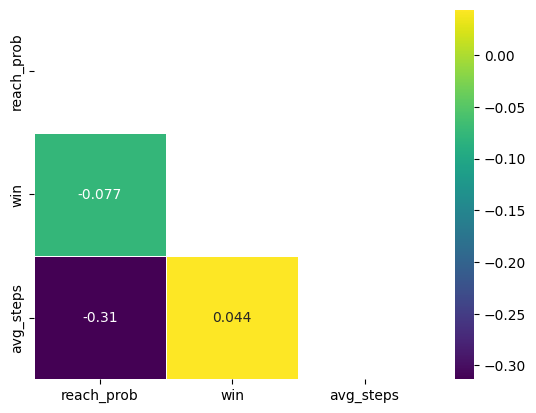

In [11]:
result_df = analyse_piece_over_all(dfs, 'queen_pos', treshold_percent)
display(result_df.head())

corr_matrix = result_df[['reach_prob', 'win', 'avg_steps']].corr()
triangle = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, mask=triangle, cmap='viridis', linewidths=0.5)
plt.show()

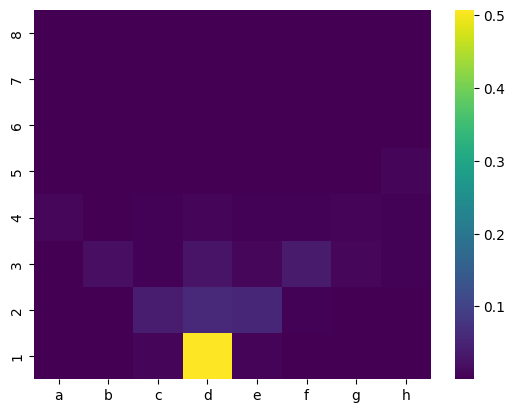

In [12]:
show_chessboard_heatmap('queen_pos')

$=>$ Vidíme, že ve většině případů se dáma nehne, zůstává na **d1(91%)** a v pak nejčastěji je na políčkách **c2(1.8%), d2(1.7%), e2(1.6%), f3(1.1%), b2(0.6%)**.\
Podíváme, jestli tyto nejčastější pozice nějak ovlivňují šanci na výhru:\
Vidíme, že dáma na políčkách **d1, c2, d2, e2 a b2** neovlivňuje šanci na výhru. Zato není zanedbatelný rozdíl **13% větší** šance na výhru, pokuď se nachází na **f3**. Je možné, že to je kvůli jednoduchému matu 3 tahy.

#### Rook

Negligible values: Index([  [4, 5],   [2, 3],  [0, 13],   [7, 8],  [0, 15],   [6, 7],   [3, 6],
        [0, 23],   [0, 2],  [0, 12],
       ...
       [20, 44],  [8, 12], [10, 39],  [0, 25], [18, 23],  [8, 10], [11, 12],
       [13, 14], [12, 20],  [0, 48]],
      dtype='object', name='rook_pos', length=260)


/home/lukastp/gitlab/chess/notebooks/my_library.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, piece_df], ignore_index=True)


Negligible values: Index([  [4, 5],   [2, 3],  [0, 13],   [7, 8],  [0, 15],   [5, 8],   [3, 6],
        [0, 20],   [6, 7],   [4, 7],
       ...
        [5, 49],  [5, 39],  [5, 12],  [6, 31],  [5, 31],  [7, 29], [22, 31],
        [7, 40],  [0, 54], [10, 12]],
      dtype='object', name='rook_pos', length=182)
Negligible values: Index([ [0, 15],   [4, 5],  [0, 13],   [7, 8],  [0, 23],   [6, 7],  [0, 21],
         [3, 6],   [2, 3],   [5, 8],
       ...
        [5, 48],  [2, 50], [23, 38],  [5, 36],  [4, 15],  [7, 43],  [6, 22],
        [3, 16], [10, 20], [16, 20]],
      dtype='object', name='rook_pos', length=177)
Negligible values: Index([  [3, 5],   [0, 3],   [3, 4],  [0, 15],   [7, 8],   [4, 5],  [0, 23],
         [2, 4],   [0, 2],   [4, 7],  [0, 13],   [1, 4],  [7, 16],   [3, 6],
        [0, 22],   [2, 3],  [0, 21],   [5, 7],   [5, 8],  [0, 31],  [7, 22],
        [0, 12],   [1, 6],  [7, 11],   [0, 1],   [6, 7],  [0, 14],  [0, 11],
        [5, 13],  [7, 10],  [0, 37],  [7, 19],  [7, 2

,position_int,position_str,reach_prob,win,lost,draw,avg_steps,median_steps,opening
16,"[0, 7]","['a1', 'h1']",0.614363,0.472461,0.527539,0.0,15.031780,12.0,Scotch Game
14,"[0, 5]","['a1', 'f1']",0.246278,0.484713,0.515287,0.0,21.439686,20.0,Scandinavian Defense: Mieses-Kotroc Variation
13,"[0, 4]","['a1', 'e1']",0.051018,0.484910,0.515090,0.0,24.235566,23.0,Scandinavian Defense: Mieses-Kotroc Variation
29,"[3, 7]","['d1', 'h1']",0.029710,0.469904,0.530096,0.0,24.025807,23.0,Van't Kruijs Opening
23,"[2, 5]","['c1', 'f1']",0.011125,0.504536,0.495464,0.0,28.332336,27.0,Modern Defense


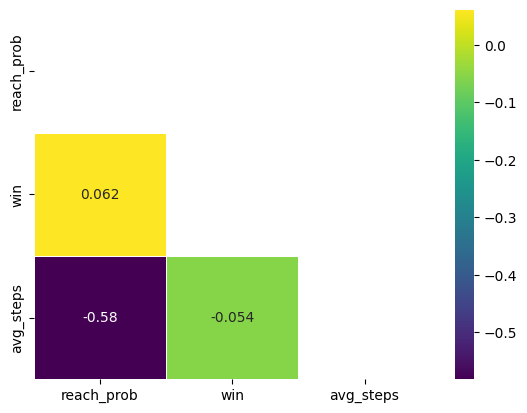

In [13]:
result_df = analyse_piece_over_all(dfs, 'rook_pos', treshold_percent)
display(result_df.head())

corr_matrix = result_df[['reach_prob', 'win', 'avg_steps']].corr()
triangle = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, mask=triangle, cmap='viridis', linewidths=0.5)
plt.show()

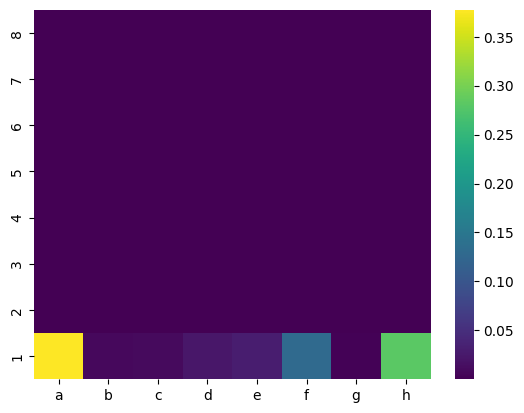

In [14]:
show_chessboard_heatmap('rook_pos')

$=>$ Vidíme, že ve většině případů se věž nehne **[a1, h1] (82.7%)**. Poté ve **12%** je udělaná malá rošáda **[a1, f1]** a ve **2%** se po ní pohne o jedno políčko doleva **[a1, e1]**. V **0.84%** je udělána velká rošáda **[d1, h1]**. Ostatní jsou zanedbatelné.

#### Bishop

Negligible values: Index([[22, 26], [26, 31], [33, 38],  [5, 18],  [5, 13], [11, 17], [14, 16],
       [12, 16], [12, 13], [19, 47],
       ...
       [34, 46], [56, 57],  [4, 40],  [7, 59], [53, 59],  [7, 27], [29, 60],
        [7, 50], [55, 63], [36, 39]],
      dtype='object', name='bishop_pos', length=628)


/home/lukastp/gitlab/chess/notebooks/my_library.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, piece_df], ignore_index=True)


Negligible values: Index([ [9, 21], [14, 47], [16, 19], [12, 13], [12, 18],  [5, 13],  [5, 18],
        [2, 30], [10, 22],   [1, 2],
       ...
       [23, 32], [16, 37], [28, 50], [23, 52], [21, 48], [16, 62], [30, 45],
       [33, 41],  [7, 27], [39, 63]],
      dtype='object', name='bishop_pos', length=590)
Negligible values: Index([[45], [39],  [3], [30], [28], [42], [34], [37],  [4], [46], [27], [43],
       [53], [63], [40],  [7], [54], [44], [25], [50], [56], [55], [32], [62],
       [49], [41], [59], [48], [57],  [6], [52], [61],  [0], [58], [51], [60]],
      dtype='object', name='bishop_pos')
Negligible values: Index([ [2, 30], [17, 47],  [5, 13], [20, 33], [26, 59],  [2, 46], [35, 38],
       [16, 19],  [2, 37], [15, 19],
       ...
       [11, 62], [22, 60], [60, 61],  [8, 27], [33, 34], [22, 23], [13, 23],
        [5, 48], [18, 23], [15, 30]],
      dtype='object', name='bishop_pos', length=371)
Negligible values: Index([[26, 47], [20, 35],  [5, 27], [19, 36],  [9, 17], [1

,position_int,position_str,reach_prob,win,lost,draw,avg_steps,median_steps,opening
145,[2],['c1'],0.363424,0.477308,0.522692,0.0,16.195354,15.0,Ruy Lopez: Steinitz Defense
106,"[2, 5]","['c1', 'f1']",0.317966,0.474283,0.525717,0.0,10.837301,9.0,Scandinavian Defense: Mieses-Kotroc Variation
191,[5],['f1'],0.153944,0.470882,0.529118,0.0,15.736972,15.0,Horwitz Defense
91,"[2, 26]","['c1', 'c4']",0.128248,0.484279,0.515721,0.0,13.636391,12.0,Sicilian Defense: Bowdler Attack
81,[19],['d3'],0.069319,0.483077,0.516923,0.0,22.139746,21.0,Horwitz Defense


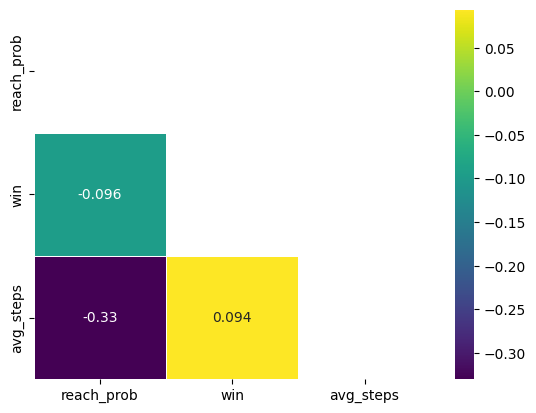

In [15]:
result_df = analyse_piece_over_all(dfs, 'bishop_pos', treshold_percent)
display(result_df.head())

corr_matrix = result_df[['reach_prob', 'win', 'avg_steps']].corr()
triangle = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, mask=triangle, cmap='viridis', linewidths=0.5)
plt.show()

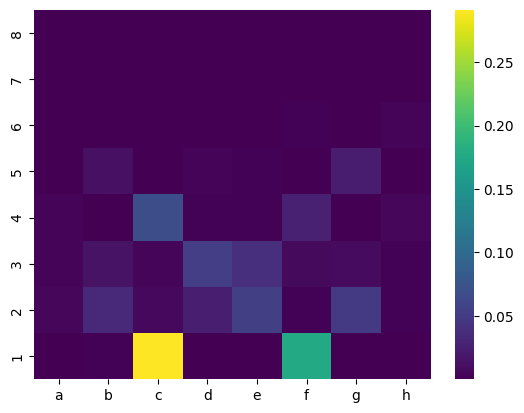

In [16]:
show_chessboard_heatmap('bishop_pos')

#### Knight

Negligible values: Index([ [4, 11], [11, 22],  [1, 17],  [1, 19], [18, 29], [11, 38],  [6, 28],
       [18, 27],  [6, 24], [18, 19],
       ...
       [41, 48], [27, 52], [29, 63],  [6, 55], [16, 56], [45, 63], [31, 52],
       [22, 54], [23, 48], [42, 46]],
      dtype='object', name='knight_pos', length=1008)


/home/lukastp/gitlab/chess/notebooks/my_library.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, piece_df], ignore_index=True)


Negligible values: Index([[30],  [8], [34], [56], [46], [39],  [2], [63], [53], [43], [42], [25],
       [41],  [9], [50], [14], [32], [44],  [7], [45], [51], [47], [52], [54],
       [49], [55], [48], [59], [61],  [0], [58], [40], [57], [60], [62]],
      dtype='object', name='knight_pos')
Negligible values: Index([[11, 22],  [6, 17],  [6, 21], [17, 18], [11, 23],  [1, 13], [12, 16],
       [12, 22],  [1, 17],  [8, 21],
       ...
        [4, 14],  [8, 33], [19, 34], [14, 15],  [0, 31], [29, 55], [27, 32],
       [14, 37],  [0, 15], [19, 56]],
      dtype='object', name='knight_pos', length=933)
Negligible values: Index([[18, 42], [11, 15],  [1, 55], [31, 35],  [4, 11], [21, 36], [21, 50],
       [21, 29], [18, 44], [11, 22],
       ...
       [34, 63], [20, 29],  [3, 27],  [0, 11], [19, 46], [53, 56], [24, 33],
        [9, 23],  [1, 58], [12, 32]],
      dtype='object', name='knight_pos', length=515)
Negligible values: Index([[43], [56], [39], [46],  [2], [63], [53], [25],  [9], [14]

,position_int,position_str,reach_prob,win,lost,draw,avg_steps,median_steps,opening
140,[21],['f3'],0.234955,0.494429,0.505571,0.0,19.835097,19.0,Scandinavian Defense: Mieses-Kotroc Variation
118,[1],['b1'],0.233542,0.492053,0.507947,0.0,15.318389,13.0,Scotch Game
7,"[1, 21]","['b1', 'f3']",0.232334,0.481150,0.518850,0.0,13.650293,11.0,French Defense: Knight Variation
115,[18],['c3'],0.229874,0.491736,0.508264,0.0,19.508258,19.0,Scandinavian Defense: Mieses-Kotroc Variation
27,"[1, 6]","['b1', 'g1']",0.212171,0.442726,0.557274,0.0,11.610708,9.0,Van't Kruijs Opening


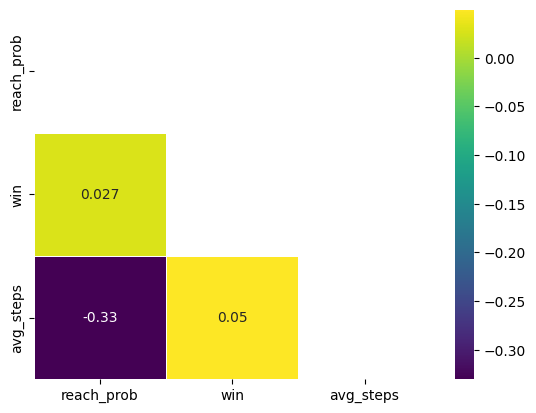

In [17]:
result_df = analyse_piece_over_all(dfs, 'knight_pos', treshold_percent)
display(result_df.head())

corr_matrix = result_df[['reach_prob', 'win', 'avg_steps']].corr()
triangle = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, mask=triangle, cmap='viridis', linewidths=0.5)
plt.show()

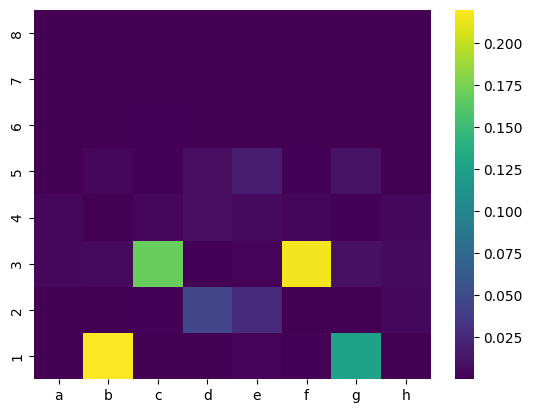

In [18]:
show_chessboard_heatmap('knight_pos')

#### Pawn

In [19]:
result_df = analyse_piece_over_all(dfs, 'pawn_pos', treshold_percent)
display(result_df.head())

corr_matrix = result_df[['reach_prob', 'win', 'avg_steps']].corr()
triangle = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, mask=triangle, cmap='viridis', linewidths=0.5)
plt.show()

Negligible values: Index([  [8, 9, 10, 13, 14, 27, 28],   [8, 9, 10, 11, 15, 22, 28],
        [9, 10, 14, 15, 16, 19, 28], [12, 13, 15, 16, 19, 22, 26],
        [8, 13, 15, 17, 20, 22, 27],  [9, 10, 12, 13, 14, 15, 16],
        [8, 11, 12, 13, 14, 15, 17],   [8, 9, 10, 13, 19, 23, 28],
        [8, 13, 14, 15, 17, 18, 20],   [8, 9, 11, 12, 13, 15, 30],
       ...
        [8, 11, 12, 14, 15, 25, 29],  [8, 11, 17, 21, 26, 31, 38],
        [9, 10, 14, 23, 28, 29, 32], [14, 15, 16, 18, 20, 25, 35],
        [8, 12, 18, 21, 22, 25, 27],  [8, 14, 18, 20, 25, 29, 34],
       [13, 14, 15, 19, 26, 28, 34],  [8, 10, 14, 15, 17, 20, 46],
       [10, 11, 16, 29, 30, 31, 36],  [9, 10, 16, 21, 30, 36, 47]],
      dtype='object', name='pawn_pos', length=45692)


KeyboardInterrupt: 

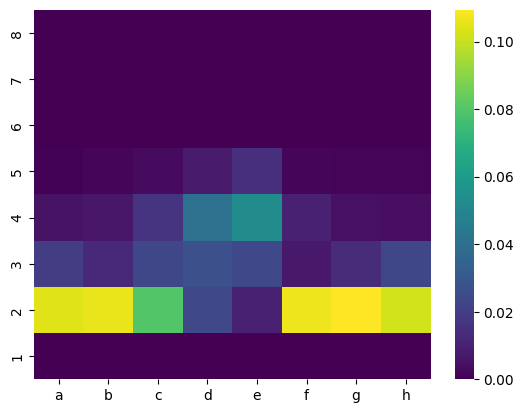

In [ ]:
show_chessboard_heatmap('pawn_pos')